# **Assessing Ocean Circulation, Carbon Uptake, and Environmental Changes** #

For an interactive version of this page please visit the Google Colab at the link:  
[<img src="https://colab.research.google.com/img/colab_favicon_256px.png" height="35px" align=CENTER> Open in Google Colab ](https://colab.research.google.com/drive/12kkH-R07M-2Vkrd7rjT3snSGgM5QbOY6)<br>
<sub>(To open link in new tab press Ctrl + click)</sub>

Alternatively this notebook can be opened with Binder by following the link:  
[Assessing Ocean Circulation, Carbon Uptake, and Environmental Changes](https://mybinder.org/v2/gh/s4oceanice/literacy.s4oceanice/main?urlpath=%2Fdoc%2Ftree%2Fnotebooks_binder%2Foceanice_cchdo_bottle.ipynb)

The purpose of this notebook is to show the use of in situ observations as CCHDO Bottle data to assess ocean circulation, carbon uptake and environemntal changes.

CCHDO (CLIVAR and Carbon Hydrographic Data Office) supports oceanographic research by providing access to high quality, global, vessel-based CTD and hydrographic data from GO-SHIP, WOCE, CLIVAR and other repeat hydrography programs. The coast-to-coast, top-to-bottom, reference-quality ocean transects curated by the CCHDO
provide a keystone in assessing and understanding the extent and nature of ocean changes. They
are used to monitor the ocean storage and transport of heat, freshwater, carbon and nutrients;
assess the ocean’s uptake of anthropogenic carbon and heat; monitor changes in ocean oxygen
and acidification; and evaluate ocean circulation and ventilation. A principal scientific use of
CCHDO data is model initiation, calibration and validation. Further, it provides critical reference
data for Argo float calibration and quality control.


The tool uses the following product:

- OCEAN ICE's ERDDAP's dataset (https://er1.s4oceanice.eu/erddap/tabledap/CCHDO_Bottle.html)

The first code cell installs and imports into the notebook all the necessary libraries to run the code of the subsequent cells. The second one retrieves a list of platforms from the CCHDO dataset, filtering them by latitude to include only those with latitude less than -55 or latitude greater than 55. It will also store in the notebook's memory some functions that will be used later. In this webpage the interactive nature of the Colab had to be made static so in this example the platform chosen will be the first in the dataframe resulting from the query.

In [5]:
!pip install cartopy

from ipywidgets import Dropdown, Layout, HBox, VBox, Output
from scipy.stats import linregress
from io import BytesIO
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import warnings

warnings.filterwarnings("ignore")

In [2]:
BASE_URL_DATASET = 'https://er1.s4oceanice.eu/erddap/tabledap/CCHDO_Bottle'

north_lat_limit = 55
south_lat_limit = -55

coords_padding = 10

def get_platforms():
    profile_ids_query_north = f'.csvp?expocode&latitude%3E={north_lat_limit}&distinct()'
    profile_ids_query_south = f'.csvp?expocode&latitude%3C={south_lat_limit}&distinct()'

    resp_north = requests.get(BASE_URL_DATASET + profile_ids_query_north)
    df_north = pd.read_csv(BytesIO(resp_north.content), encoding='utf-8')

    resp_south = requests.get(BASE_URL_DATASET + profile_ids_query_south)
    df_south = pd.read_csv(BytesIO(resp_south.content), encoding='utf-8')

    frames = [df_north, df_south]
    df_platforms = pd.concat(frames)

    platforms = list(df_platforms['expocode'])
    return platforms, df_platforms

def var_name_uom_map():
    metadata_url = 'https://er1.s4oceanice.eu/erddap/info/CCHDO_Bottle/index.csv'
    resp_metadata = requests.get(metadata_url)
    df_metadata = pd.read_csv(BytesIO(resp_metadata.content), header=0, encoding='utf-8')

    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_error', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_qc', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_unk', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('_68', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('ref_', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('rev_', na=False)]
    df_metadata = df_metadata[~df_metadata['Variable Name'].str.contains('bottle_', na=False)]
    df_metadata.reset_index(drop=True, inplace=True)

    variable_long_name_map = {}
    variable_units_map = {}

    current_variable = None
    for index, row in df_metadata.iterrows():
        if row['Row Type'] == 'variable':
            current_variable = row['Variable Name']
            variable_long_name_map[current_variable] = current_variable
            variable_units_map[current_variable] = ''

        elif row['Row Type'] == 'attribute' and current_variable:
            if row['Attribute Name'] == 'long_name':
                variable_long_name_map[current_variable] = row['Value']
            elif row['Attribute Name'] == 'units':
                unit = row['Value'] if row['Value'] != 'Unknown' else ''
                unit = unit.encode('utf-8').decode('unicode_escape')
                variable_units_map[current_variable] = unit

    variable_units_map['time'] = ''
    variable_units_map['ctd_salinity'] = 'psu'

    return variable_long_name_map, variable_units_map

def get_filtered_variable_map(selected_platform, variable_long_name_map, non_valid_vars=None, additional_vars=None):
    data_query = f'.csv?&expocode=%22{selected_platform}%22'
    resp = requests.get(BASE_URL_DATASET + data_query)
    df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')
    df = df.iloc[1:]
    df.dropna(axis=1, how='all', inplace=True)
    df.dropna(axis=0, how='all', inplace=True)

    all_vars = list(df.columns)

    filtered_variable_long_name_map = {k: v for k, v in variable_long_name_map.items() if k in all_vars}

    if additional_vars:
        filtered_variable_long_name_map.update(additional_vars)

    for non_valid_var in non_valid_vars:
        filtered_variable_long_name_map.pop(non_valid_var, None)

    long_name_to_variable_map = {v: k for k, v in filtered_variable_long_name_map.items()}

    return filtered_variable_long_name_map, long_name_to_variable_map

platforms, df_platforms = get_platforms()

selected_platform = platforms[0]

dropdown_platforms = Dropdown(
    options=platforms,
    value=platforms[0],
    description='Select a platform:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

output_plot = Output()

def update_plot():
    with output_plot:
        output_plot.clear_output(wait=True)
        data_query = f'.csv?time%2Clatitude%2Clongitude&expocode=%22{selected_platform}%22'
        resp = requests.get(BASE_URL_DATASET + data_query)
        df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')

        if df.empty:
            print("No data available for the selected platform.")
            return

        df = df.iloc[1:]
        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)

        min_lat, mean_lat, max_lat = df['latitude'].min(), df['latitude'].mean(), df['latitude'].max()
        min_lon, mean_lon, max_lon = df['longitude'].min(), df['longitude'].mean(), df['longitude'].max()

        lat_range = max_lat - min_lat
        lon_range = max_lon - min_lon
        max_range = max(lat_range, lon_range)

        lat_buffer = (max_range - lat_range) / 2 + coords_padding
        lon_buffer = (max_range - lon_range) / 2 + coords_padding

        projection = ccrs.PlateCarree()

        fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': projection})

        ax.add_feature(cfeature.LAND, edgecolor='black')
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        ax.plot(df['longitude'], df['latitude'], marker='.', linestyle='-', color='lime', transform=ccrs.PlateCarree())
        ax.set_title(f'Trajectory for Platform: {selected_platform}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        ax.set_xticks([min_lon - lon_buffer, mean_lon, max_lon + lon_buffer])
        ax.set_yticks([min_lat - lat_buffer, mean_lat, max_lat + lat_buffer])

        ax.set_xlim(min_lon - lon_buffer, max_lon + lon_buffer)
        ax.set_ylim(max(min_lat - lat_buffer, -90), min(max_lat + lat_buffer, 90))

        plt.show()

def on_change(change):
    global selected_platform
    if dropdown_platforms.value:
        selected_platform = dropdown_platforms.value
        update_plot()

dropdown_platforms.observe(on_change, names='value')

hbox = VBox([dropdown_platforms, output_plot])

display(hbox)

update_plot()

## Visualize the correlation between two parameters for the selected platform

In [3]:
variable_long_name_map, units_map = var_name_uom_map()
non_valid_vars = ['time', 'latitude', 'longitude', 'profile_id', 'expocode', 'station', 'section_id', 'line_id', 'cast', 'sample', 'bottle_number', 'profile_type']
filtered_variable_long_name_map, long_name_to_variable_map = get_filtered_variable_map(selected_platform, variable_long_name_map, non_valid_vars=non_valid_vars)

first_var = 'pressure'
second_var = 'time'

x_scale = 'Linear'
y_scale = 'Linear'

dropdown_1 = Dropdown(
    options=list(long_name_to_variable_map.keys()),
    value='Sea Water Pressure',
    description='Y axis variable:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

dropdown_2 = Dropdown(
    options=list(long_name_to_variable_map.keys()),
    value='Sea Water Temperature',
    description='X axis variable:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

x_scale_dropdown = Dropdown(
    options=['Linear', 'Logarithmic'],
    value='Linear',
    description='Choose the scale:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

y_scale_dropdown = Dropdown(
    options=['Linear', 'Logarithmic'],
    value='Linear',
    description='Choose the scale:',
    layout=Layout(width='300px'),
    style={'description_width': 'initial'}
)

def on_change(change):
    global first_var
    global second_var
    global x_scale
    global y_scale
    if dropdown_1.value and dropdown_2.value and x_scale_dropdown.value and y_scale_dropdown.value:
        first_var = long_name_to_variable_map[dropdown_1.value]
        second_var = long_name_to_variable_map[dropdown_2.value]
        y_scale = y_scale_dropdown.value
        x_scale = x_scale_dropdown.value

dropdown_1.observe(on_change, names='value')
dropdown_2.observe(on_change, names='value')

x_scale_dropdown.observe(on_change, names='value')
y_scale_dropdown.observe(on_change, names='value')

vbox_1 = VBox([dropdown_1, dropdown_2])
vbox_2 = VBox([y_scale_dropdown, x_scale_dropdown])

hbox = HBox([vbox_1, vbox_2])
display(hbox)

on_change(None)

The next code cell generates a scatter plot with two between the avilable variables for the selected platform . It fetches the data from the server, filters, and sorts it based on the chosen variables. It colors the data points by time, creating a color-coded legend for profile times. The plot will automatically adjust to these settings for accurate analysis.

In this plot, a linear regression is also applied to show the relationship between the two selected variables. Linear regression is a statistical method used to model the relationship between two variables by fitting a straight line through the data. The line represents the best estimate of how one variable  changes in response to the other variable. Below the plot the R-squared and p-value obtained from the linear regression will be shown.

- R-squared (R²): This value represents how well the regression line fits the data. It ranges from 0 to 1, where 1 means a perfect fit. A higher R² means that the line explains a larger portion of the variance in the data.

- P-value: This tells us whether the relationship between the variables is statistically significant. A small p-value (typically less than 0.05) suggests that the correlation is likely not due to chance, implying a strong association between the variables.

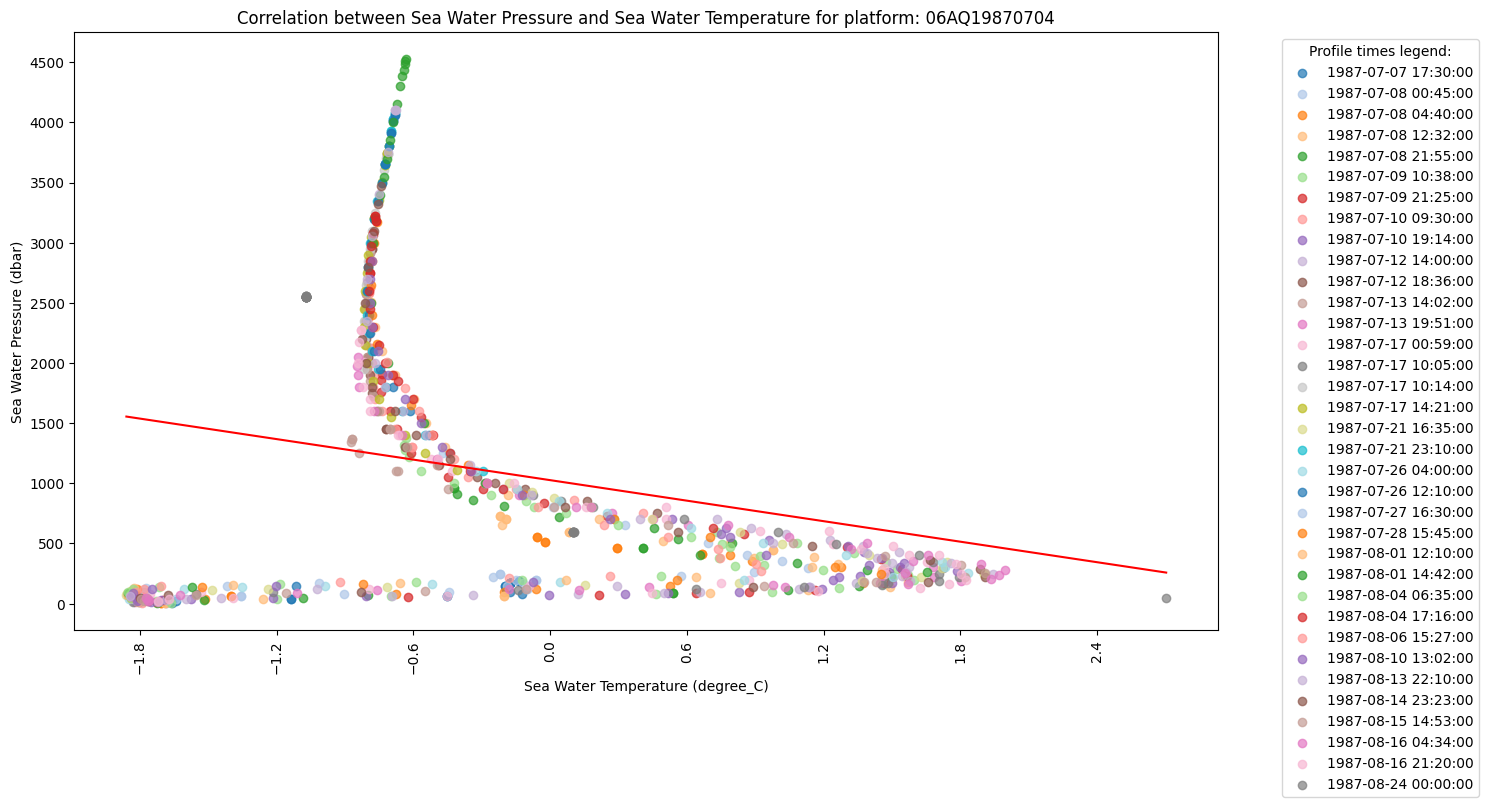

Linear Regression:
R² = 0.06
P-value = 4.0832586437952553e-13


In [6]:
if first_var != 'time' and second_var != 'time':
    if first_var == second_var:
        data_query = f'.csv?time%2C{first_var}%2Cprofile_id&expocode=%22{selected_platform}%22'
    else:
        data_query = f'.csv?time%2C{first_var}%2C{second_var}%2Cprofile_id&expocode=%22{selected_platform}%22'
else:
    if first_var == second_var:
        data_query = f'.csv?{first_var}%2Cprofile_id&expocode=%22{selected_platform}%22'
    else:
        data_query = f'.csv?{first_var}%2C{second_var}%2Cprofile_id&expocode=%22{selected_platform}%22'

resp = requests.get(BASE_URL_DATASET + data_query)
df = pd.read_csv(BytesIO(resp.content), header=0, encoding='utf-8')
df = df.iloc[1:]

df[first_var] = pd.to_numeric(df[first_var], errors='coerce')
df[second_var] = pd.to_numeric(df[second_var], errors='coerce')

df = df.dropna(subset=[first_var, second_var])
df = df.sort_values(by=[second_var, first_var])

time_values = sorted(df['time'].unique())
palette = sns.color_palette("tab20", len(time_values))
profile_colors = dict(zip(time_values, palette))

plt.figure(figsize=(15, 8))

for t in time_values:
    mask = df['time'] == t
    plt.scatter(
        df.loc[mask, second_var],
        df.loc[mask, first_var],
        color=profile_colors[t],
        label=t.replace('T', ' ').replace('Z', ''),
        alpha=0.7
    )

if len(df) > 0:
    slope, intercept, r_value, p_value, std_err = linregress(df[second_var], df[first_var])
    x_range = np.linspace(df[second_var].min(), df[second_var].max(), 100)
    regression_line = slope * x_range + intercept

    plt.plot(x_range, regression_line, color='red')

plt.ylabel(filtered_variable_long_name_map[first_var] + ' (' + units_map[first_var] + ')' if units_map[first_var] else filtered_variable_long_name_map[first_var])
plt.xlabel(filtered_variable_long_name_map[second_var] + ' (' + units_map[second_var] + ')' if units_map[second_var] else filtered_variable_long_name_map[second_var])

ax = plt.gca()
ax.set_title(f'Correlation between {filtered_variable_long_name_map[first_var]} and {filtered_variable_long_name_map[second_var]} for platform: {selected_platform}')

ax.set_xscale('log' if x_scale == 'Logarithmic' else 'linear')
ax.set_yscale('log' if y_scale == 'Logarithmic' else 'linear')

if x_scale == 'Logarithmic':
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0))

if y_scale == 'Logarithmic':
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))

ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))

plt.legend(title='Profile times legend:', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f'Linear Regression:\nR² = {r_value**2:.2f}\nP-value = {p_value}')

## Compare two different parameters for a selected profile

In [ ]:
time_pres_query = f'.csv?time%2Cpressure&expocode=%22{selected_platform}%22'
resp_tp = requests.get(BASE_URL_DATASET + time_pres_query)
df_time_pres = pd.read_csv(BytesIO(resp_tp.content), header=0, encoding='utf-8')
df_time_pres = df_time_pres.iloc[1:]
time_values = list(df_time_pres['time'].unique())
time_values = sorted(time_values)

pres_values = list(df_time_pres['pressure'])
pres_values = sorted([float(x) for x in pres_values])

variable_long_name_map_2, units_map_2 = var_name_uom_map()
non_valid_vars_2 = ['time', 'latitude', 'longitude', 'profile_id', 'expocode', 'station', 'section_id', 'line_id', 'cast', 'sample', 'bottle_number', 'profile_type']
variable_long_name_map_2, long_name_to_variable_map_2 = get_filtered_variable_map(selected_platform, variable_long_name_map_2, non_valid_vars=non_valid_vars_2)
del variable_long_name_map_2['pressure']
del long_name_to_variable_map_2['Sea Water Pressure']

selected_t = time_values[0].replace('T', ' ').replace('Z', '')
selected_param = list(variable_long_name_map_2.values())[1]
selected_param_2 = list(variable_long_name_map_2.values())[2]

times_dropdown = Dropdown(
    options=[t.replace('T', ' ').replace('Z', '') for t in time_values],
    value=time_values[0].replace('T', ' ').replace('Z', ''),
    description='Time value (profile):',
    layout=Layout(width='400px'),
    style={'description_width': '150px'}
)

param_dropdown = Dropdown(
    options=list(long_name_to_variable_map_2.keys()),
    value=selected_param,
    description='First parameter:',
    layout=Layout(width='400px'),
    style={'description_width': '150px'}
)

param_dropdown_2 = Dropdown(
    options=list(long_name_to_variable_map_2.keys()),
    value=selected_param_2,
    description='Second parameter:',
    layout=Layout(width='400px'),
    style={'description_width': '150px'}
)


def on_change(change):
    global selected_t
    global selected_param
    global selected_param_2
    if times_dropdown.value and param_dropdown.value and param_dropdown_2.value:
        selected_t = times_dropdown.value.replace(' ', 'T') + 'Z'
        selected_param = long_name_to_variable_map_2[param_dropdown.value]
        selected_param_2 = long_name_to_variable_map_2[param_dropdown_2.value]

times_dropdown.observe(on_change, names='value')
param_dropdown.observe(on_change, names='value')
param_dropdown_2.observe(on_change, names='value')

display(times_dropdown, param_dropdown, param_dropdown_2)

on_change(None)

Dropdown(description='Time value (profile):', layout=Layout(width='400px'), options=('1987-07-07 17:30:00', '1…

Dropdown(description='First parameter:', index=1, layout=Layout(width='400px'), options=('Sea Floor Depth Belo…

Dropdown(description='Second parameter:', index=2, layout=Layout(width='400px'), options=('Sea Floor Depth Bel…

The last code cell generates a plot with depth on the y-axis and two variables available for the platform's profile on two x-axes (one for each variable). This allows the user to explore how the two parameters change with depth.

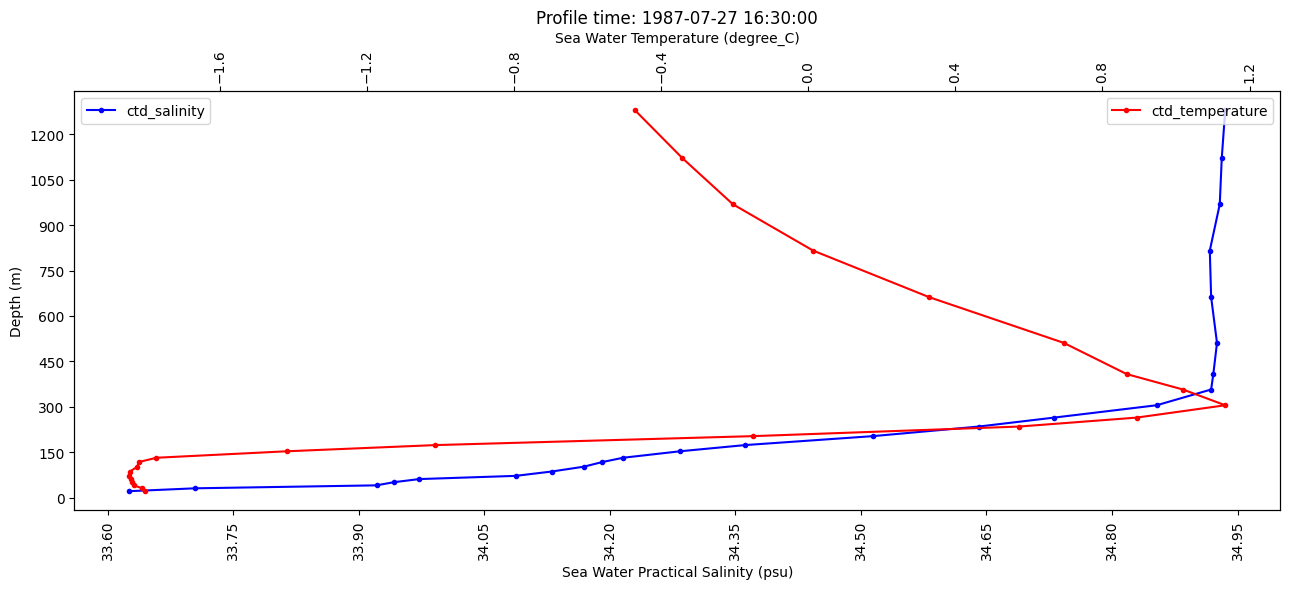

In [ ]:
assert selected_param != selected_param_2, "Selected parameters cannot be the same. Please choose two different parameters."

data_query = f'.csv?{selected_param}%2C{selected_param_2}%2Cpressure%2Ctime&expocode=%22{selected_platform}%22&time={selected_t}'

data_resp = requests.get(BASE_URL_DATASET + data_query)
df = pd.read_csv(BytesIO(data_resp.content), header=0, encoding='utf-8')
df = df.iloc[1:]

df['pressure'] = pd.to_numeric(df['pressure'], errors='coerce')
df[selected_param] = pd.to_numeric(df[selected_param], errors='coerce')
df[selected_param_2] = pd.to_numeric(df[selected_param_2], errors='coerce')

df = df.dropna(subset=['pressure', selected_param, selected_param_2])

df['depth'] = df['pressure'] * 1.01998

time_groups = df.groupby('time')

valid_time_data = time_groups.apply(lambda x: x.dropna(subset=['pressure', selected_param]))

selected_time_data = valid_time_data[valid_time_data['time'] == selected_t]

if selected_time_data.empty:
    available_times_with_data = valid_time_data['time'].unique()

    if len(available_times_with_data) > 0:
        print(f"No data found for the selected time ({selected_t}).")
        print(f"Here are some times that have valid data for {selected_param}:")
        print(available_times_with_data)
    else:
        print(f"No valid data found for {selected_param} across all times.")
else:
    depth_values = selected_time_data['depth']
    pres_values = selected_time_data['pressure']

    param_values = selected_time_data[selected_param]
    param_values_2 = selected_time_data[selected_param_2]

    fig, ax1 = plt.subplots(figsize=(13, 6))

    ax1.set_title(f"Profile time: {selected_t.replace('T', ' ').replace('Z', '')}")

    ax1.plot(param_values, depth_values, marker='.', color='b', label=f'{selected_param}')
    ax1.set_xlabel(f"{variable_long_name_map_2[selected_param]} ({units_map_2[selected_param]})" if units_map_2[selected_param] else variable_long_name_map_2[selected_param])
    ax1.set_ylabel('Depth (m)')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))
    ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='lower'))

    ax2 = ax1.twiny()
    ax2.plot(param_values_2, depth_values, marker='.', color='r', label=f'{selected_param_2}')
    ax2.set_xlabel(f"{variable_long_name_map_2[selected_param_2]} ({units_map_2[selected_param_2]})" if units_map_2[selected_param_2] else variable_long_name_map_2[selected_param_2])

    ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='lower'))

    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

### **Additional resources**

CCHDO's website:
- https://cchdo.ucsd.edu/

The Python libraries that have been used in this notebook are:
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)
- [scipy](https://scipy.org/)
- [requests](https://requests.readthedocs.io/en/latest/)
- [seaborn](https://seaborn.pydata.org/)
- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [matplotlib](https://matplotlib.org/)